### Modellare la volatilità con i modelli ARCH e GARCH

Fonti:
- Lewinson 2020 Python for Finance Cookbook - cap. 5
- Yan 2017 Python for Finance - cap. 15

Parliamo di "eteroschedasticità condizionale" quando la variazioni della volatilità sono collegate fra loro. Abbiamo visto nel laboratorio sulla diagnostica delle serie temporali che la volatilità del rendimento di un titolo o di un portafoglio tende a subire improvvisi aumenti e poi a rimanere per un certo periodo su livelli più alti. Stesso comportamento abbiamo osservato nell'indice VIX, che misura la volatilità implicita nelle opzioni sull'indice S&P500

#### Modello ARCH (AutoRegressive Conditional Heteroskedasticity

$
r_t = \mu + \epsilon_t
$

$
\epsilon_t = \sigma_t z_t
$

$
\sigma^{2}_{t} = \omega + \sum_{i=1}^q a_i \epsilon^{2}_{t-i}\
$

dove
$
\omega > 0
$
$
\alpha_i >= 0
$

#### 1.Simulazione di un processo ARCH(1)

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(12345)
n = 1000 
#n1 = 1
#n2 = n + n1


Per la simulazione la varianza non condizionale del modello ARCH è uguale a

$
\frac {\omega} {(1 - \alpha_i)}
$

Nel codice sotto a0 e a1


In [3]:
a = (0.1, 0.3)
errors = np.random.normal(0,1,n)
t = np.zeros(n)
t[0] = np.random.normal(0, np.sqrt(a[0] / (1 - a[1])), 1)
for i in range(1,n-1):
    t[i] = errors[i]*np.sqrt(a[0] + a[1]*t[i-1]**2)
    y = t#[n1-1:-1]

C:\Users\s.bencini\AppData\Local\Temp\ipykernel_31812\2725768547.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t[0] = np.random.normal(0, np.sqrt(a[0] / (1 - a[1])), 1)


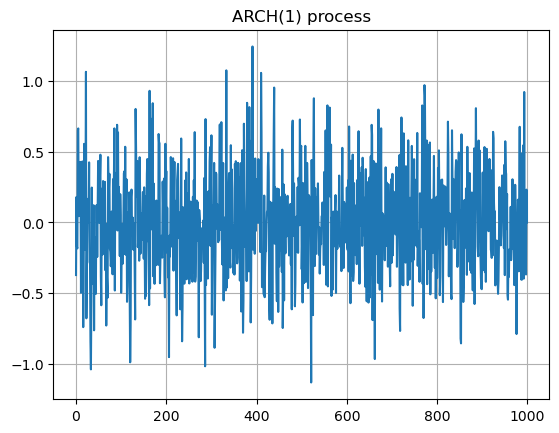

In [4]:
plt.title('ARCH(1) process')
x = range(n)
plt.plot(x,y)
plt.grid(True)
plt.show();

#### 2. Stima di un modello ARCH

In [5]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [6]:
from arch import arch_model
from datetime import date, datetime
import pandas as pd
#import pandas_datareader.data as web
import yfinance as yf

In [9]:
start_date = '2014-05-31'
end_date = '2024-05-31'
#end_date = datetime.today()
titolo = '^GSPC'

In [10]:
df = yf.download(titolo, start_date, end_date) 

[*********************100%%**********************]  1 of 1 completed


In [11]:
returns = df['Adj Close'].pct_change().dropna()
#returns = df['Adj Close'].pct_change().dropna()
returns.name = 'asset_returns'

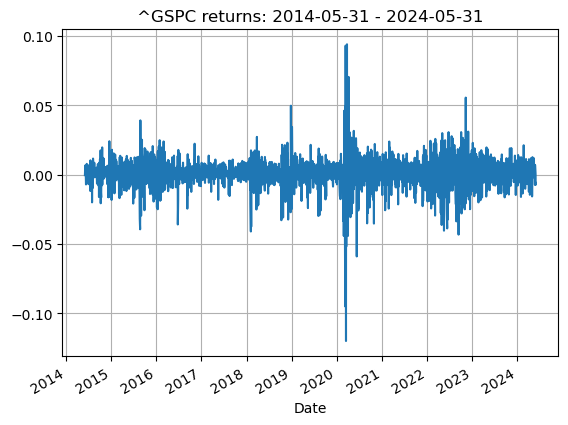

In [12]:
returns.plot(title=f'{titolo} returns: {start_date} - {end_date}', grid=True);

In [13]:
model = arch_model(returns, mean = 'Zero', vol='ARCH', p = 1, o = 0, q = 0)

In [14]:
model_fitted = model.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: -5906.266553315986
Iteration:      2,   Func. Count:     10,   Neg. LLF: -7573.716415282239
Iteration:      3,   Func. Count:     15,   Neg. LLF: 3545013.1658434942
Iteration:      4,   Func. Count:     21,   Neg. LLF: -8067.96851253075
Iteration:      5,   Func. Count:     24,   Neg. LLF: -8067.968511222983
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8067.968512530744
            Iterations: 5
            Function evaluations: 34
            Gradient evaluations: 5


C:\Users\s.bencini\AppData\Local\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [15]:
returns = 100 * df['Adj Close'].pct_change().dropna()

In [16]:
model = arch_model(returns, mean = 'Zero', vol='ARCH', p = 1, o = 0, q = 0)

arch_model fa due cose: prima stima un modello ARIMA e poi con residui stima il modello ARCH

In [17]:
#come in scikit-learn prima si crea il modello e poi si stima con il metodo "fit"
model_fitted = model.fit(disp='off')

In [18]:
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3518.64
Distribution:                  Normal   AIC:                           7041.28
Method:            Maximum Likelihood   BIC:                           7052.94
                                        No. Observations:                 2516
Date:                Thu, Jun 06 2024   Df Residuals:                     2516
Time:                        16:44:49   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6511  4.145e-02     15.709  1.321e-55 [  0.570,  0.73

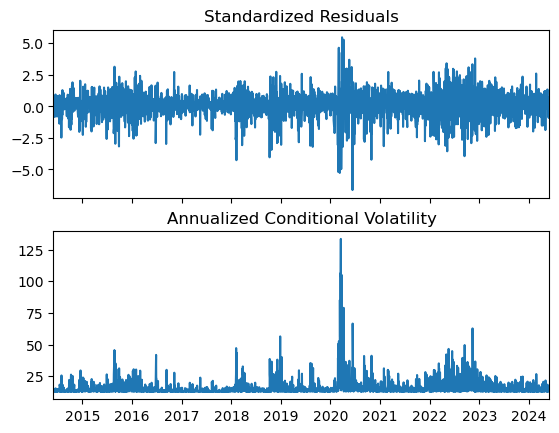

In [19]:
model_fitted.plot(annualize = 'D');

I residui standardizzati (standardized residuals) sono ottenuti dividendo i residui per la volatilità condizionale
La 'D' indica che vogliamo annualizzare la volatilità condizionale partendo da dati giornalieri

#### Modello GARCH (Generalized AutoRegressive Conditional Heteroskedasticity

$
r_t = \mu + \epsilon_t
$

$
\epsilon_t = \sigma_t z_t
$

$
\sigma^{2}_{t} = \omega + \sum_{i=1}^q a_i \epsilon^{2}_{t-i} + \sum_{i=1}^p \beta_i \sigma^{2}_{t-i}
$

dove
$
\omega > 0,
$
$
\alpha_i >= 0,
$
$
\beta_i >= 0,
$
$
\alpha_i + \beta_i < 1\
$

#### 1. Simulazione di un processo GARCH(1,1)

In [20]:
np.random.seed(12345)
n = 1000 
a = (0.1, 0.3) #coefficienti del processo ARCH
alpha = (0.1, 0.3) #coefficienti del processo GARCH
beta = 0.2
errors = np.random.normal(0,1,n)
t = np.zeros(n)
t[0] = np.random.normal(0, np.sqrt(a[0] / (1 - a[1])), 1)
for i in range(1,n-1):
    t[i] = errors[i]*np.sqrt(alpha[0] + alpha[1]*errors[i-1]**2 + beta*t[i-1]**2)
    y = t#[n1-1:-1]
    


C:\Users\s.bencini\AppData\Local\Temp\ipykernel_31812\3612273507.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t[0] = np.random.normal(0, np.sqrt(a[0] / (1 - a[1])), 1)


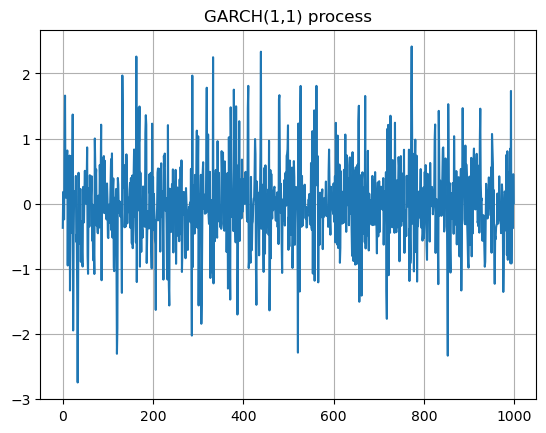

In [21]:
plt.title('GARCH(1,1) process')
x = range(n)
plt.plot(x,y)
plt.grid(True)
plt.show();

C:\Users\s.bencini\AppData\Local\Temp\ipykernel_31812\3019687798.py:13: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  t=sp.zeros(n2)
C:\Users\s.bencini\AppData\Local\Temp\ipykernel_31812\3019687798.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t[0]=np.random.normal(0,np.sqrt(a[0]/(1-a[1])),1)


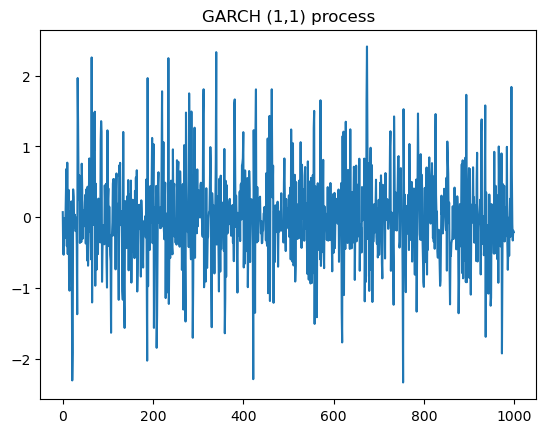

In [22]:
import scipy as sp 
import matplotlib.pyplot as plt
#
np.random.seed(12345)
n=1000          # n is the number of observations
n1=100          # we need to drop the first several observations 
n2=n+n1         # sum of two numbers
#
a=(0.1,0.3)     # ARCH coefficient
alpha=(0.1,0.3)    # GARCH (1,1) coefficients alpha0 and alpha1, see Equation (3)
beta=0.2 
errors=np.random.normal(0,1,n2) 
t=sp.zeros(n2)
t[0]=np.random.normal(0,np.sqrt(a[0]/(1-a[1])),1)
#
for i in range(1,n2-1): 
    t[i]=errors[i]*np.sqrt(alpha[0]+alpha[1]*errors[i-1]**2+beta*t[i-1]**2)
#
y=t[n1-1:-1]    # drop the first n1 observations 
plt.title('GARCH (1,1) process')
x=range(n) 
plt.plot(x,y)
plt.show()

#### 2. Stima di un processo GARCH

In [23]:
model = arch_model(returns, mean = 'Zero', vol='GARCH', p = 1, o = 0, q = 1)

In [24]:
model_fitted = model.fit(disp = 'off')
print(model_fitted.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3206.84
Distribution:                  Normal   AIC:                           6419.69
Method:            Maximum Likelihood   BIC:                           6437.18
                                        No. Observations:                 2516
Date:                Thu, Jun 06 2024   Df Residuals:                     2516
Time:                        16:46:39   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0359  9.219e-03      3.894  9.866e-05 [1.

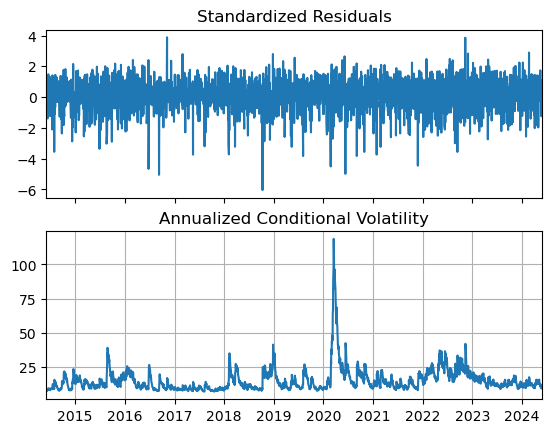

In [25]:
model_fitted.plot(annualize='D')
plt.grid();

Poiché abbiamo inserito nel modello la volatilità passata la volatilità condizionale impiega più tempo a tornare ai livelli medi dopo ogni picco

### Modello Constant Conditional Correlation - GARCH per prevedere la volatilità multivariata
Il modello consiste in N modelli GARCH univariati messi in relazione fra di loro da una matrice di correlazioni condizionali costante R

In [26]:
titoli = ['GOOG', 'MSFT', 'AAPL']
N = len(titoli)
start_date = '2014-05-31'
end_date = '2024-05-31'


In [27]:
df = yf.download(titoli, start_date, end_date) 

[*********************100%%**********************]  3 of 3 completed


Ticker,AAPL,GOOG,MSFT
Date,,,
2014-06-03,1.414103,-1.622947,-1.225789
2014-06-04,1.141915,-0.051375,0.074466
2014-06-05,0.392346,1.696465,2.207319
2014-06-06,-0.274946,0.438710,0.655246
2014-06-09,1.600117,1.040744,-0.506320
...,...,...,...
2024-05-23,-2.105809,-1.651687,-0.817613
2024-05-24,1.658814,0.725468,0.740048
2024-05-28,0.005269,0.958432,0.037196


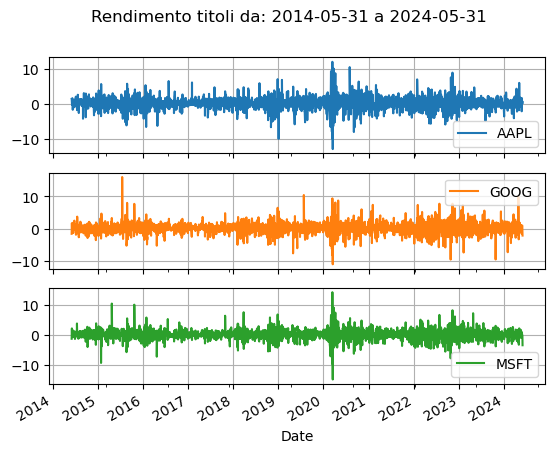

In [28]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.plot(subplots = True, grid=True, title=f'Rendimento titoli da: {start_date} a {end_date}');
returns

Matrice di varianze covarianze

In [29]:
returns.cov()

Ticker,AAPL,GOOG,MSFT
Ticker,,,
AAPL,3.182976,1.912511,2.059940
GOOG,1.912511,3.141166,2.151468
MSFT,2.059940,2.151468,2.903014


In [30]:
returns.corr()

Ticker,AAPL,GOOG,MSFT
Ticker,,,
AAPL,1.000000,0.604842,0.677662
GOOG,0.604842,1.000000,0.712467
MSFT,0.677662,0.712467,1.000000


In [31]:
coeffs = []
cond_vol = []
std_resids = []
models = []

In [32]:
for asset in returns.columns:
    model = arch_model(returns[asset], mean = 'Constant', vol='GARCH',
                       p = 1, o = 0, q = 1).fit(update_freq = 0, disp = 'off')
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.resid / model.conditional_volatility)
    models.append(model)
    

In [33]:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = pd.DataFrame(cond_vol).transpose().set_axis(returns.columns,
                                                         axis='columns')
std_resids_df = pd.DataFrame(std_resids).transpose().set_axis(returns.columns,
                                                             axis = 'columns')

In [34]:
coeffs_df

,mu,omega,alpha[1],beta[1]
Ticker,,,,
AAPL,0.167806,0.140022,0.102682,0.851726
GOOG,0.091834,0.155434,0.101950,0.853541
MSFT,0.136564,0.218133,0.171179,0.759740


In [35]:
cond_vol_df

Ticker,AAPL,GOOG,MSFT
Date,,,
2014-06-03,1.011311,1.148547,1.017887
2014-06-04,1.081950,1.257447,1.150219
2014-06-05,1.111080,1.227649,1.106314
2014-06-06,1.093917,1.305499,1.371868
2014-06-09,1.085989,1.273741,1.301550
...,...,...,...
2024-05-23,1.369484,1.498793,1.164395
2024-05-24,1.506060,1.543608,1.184927
2024-05-28,1.516639,1.493359,1.160685


In [36]:
std_resids_df

Ticker,AAPL,GOOG,MSFT
Date,,,
2014-06-03,1.232358,-1.493001,-1.338413
2014-06-04,0.900327,-0.113889,-0.053987
2014-06-05,0.202092,1.307077,1.871760
2014-06-06,-0.404740,0.265704,0.378085
2014-06-09,1.318900,0.744978,-0.493937
...,...,...,...
2024-05-23,-1.660198,-1.163284,-0.819461
2024-05-24,0.990005,0.410489,0.509301
2024-05-28,-0.107169,0.580301,-0.085611


Calcoliamo la matrice di correlazioni costanti condizionali 

In [37]:
R = std_resids_df.transpose().dot(std_resids_df).div(len(std_resids_df))

In [38]:
R

Ticker,AAPL,GOOG,MSFT
Ticker,,,
AAPL,0.999669,0.536573,0.571089
GOOG,0.536573,0.999813,0.651255
MSFT,0.571089,0.651255,1.000164


Calcoliamo la previsione della matrice di covarianze condizionale per la prossima osservazione

In [39]:
#from arch.__future__ import reindexing
diag = []
D = np.zeros((N,N))
for model in models:
    diag.append(model.forecast(horizon=1).variance.values[-1][0])
diag = np.sqrt(np.array(diag))
np.fill_diagonal(D, diag)
H = np.matmul(np.matmul(D, R.values), D)

In [40]:
H

array([[1.79660772, 1.10968413, 1.3776338 ],
       [1.10968413, 2.37936913, 1.80781452],
       [1.3776338 , 1.80781452, 3.23842129]])

### Stima di un modello GARCH
https://www.youtube.com/watch?v=3boMYvIzGQ8&ab_channel=NEDL

In [41]:
import yfinance as yf
import scipy.optimize as spop

In [42]:
ticker = '^GSPC'
start = '2014-05-31'
end = '2024-05-31'
prices = yf.download(ticker, start, end)['Close']

[*********************100%%**********************]  1 of 1 completed


In [43]:
returns = np.array(prices)[1:]/prices[:-1] - 1
mean = np.average(returns)
var = np.std(returns)**2

Funzione per stima GARCH con massima verosimiglianza

In [44]:
def garch_mle(params):
    #parametri del modello
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    #volatilità di lungo periodo
    long_run = (omega/(1-alpha-beta))**(1/2)
    #calcolo della volatilità realizzata e condizionale
    resid = returns - mu
    realized = abs(resid)
    conditional = np.zeros(len(returns))
    conditional[0] = long_run
    for t in range(1, len(returns)):
        conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
    # calcolo della verosimiglianza logaritmica
    likelihood = 1/((2*np.pi)**(1/2)*conditional)*np.exp(-realized**2/(2*conditional**2))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood


Massimizzazione verosimiglianza logaritmica

In [45]:
res = spop.minimize(garch_mle, [mean, var, 0, 0], method='Nelder-Mead')
#estrazione dei parametri ottimali
params = res.x
mu = res.x[0]
omega = res.x[1]
alpha = res.x[2]
beta = res.x[3]
log_likelihood = -float(res.fun)
#calcolo della volatilità realizzata e condizionale con i parametri ottimali
long_run = (omega/(1 - alpha - beta))**(1/2)
resid = returns - mu
realized = abs(resid)
conditional = np.zeros(len(returns))
conditional[0] = long_run
for t in range(1, len(returns)):
        conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)


C:\Users\s.bencini\AppData\Local\Temp\ipykernel_31812\3085707486.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
C:\Users\s.bencini\AppData\Local\Temp\ipykernel_31812\3085707486.py:8: RuntimeWarning: invalid value encountered in scalar power
  long_run = (omega/(1-alpha-beta))**(1/2)
C:\Users\s.bencini\AppData\Local\Temp\ipykernel_31812\4134689517.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)


In [46]:
print('GARCH model parameters')
print('')
print('mu '+str(round(mu,6)))
print('omega '+str(round(omega,6)))
print('alpha '+str(round(alpha,6)))
print('beta '+str(round(beta,6)))
print('long run volatility '+str(round(long_run,6)))
print('log likelihood '+str(round(log_likelihood,6)))


GARCH model parameters

mu 0.000806
omega 4e-06
alpha 0.186398
beta 0.779298
long run volatility 0.010596
log likelihood 8392.688838


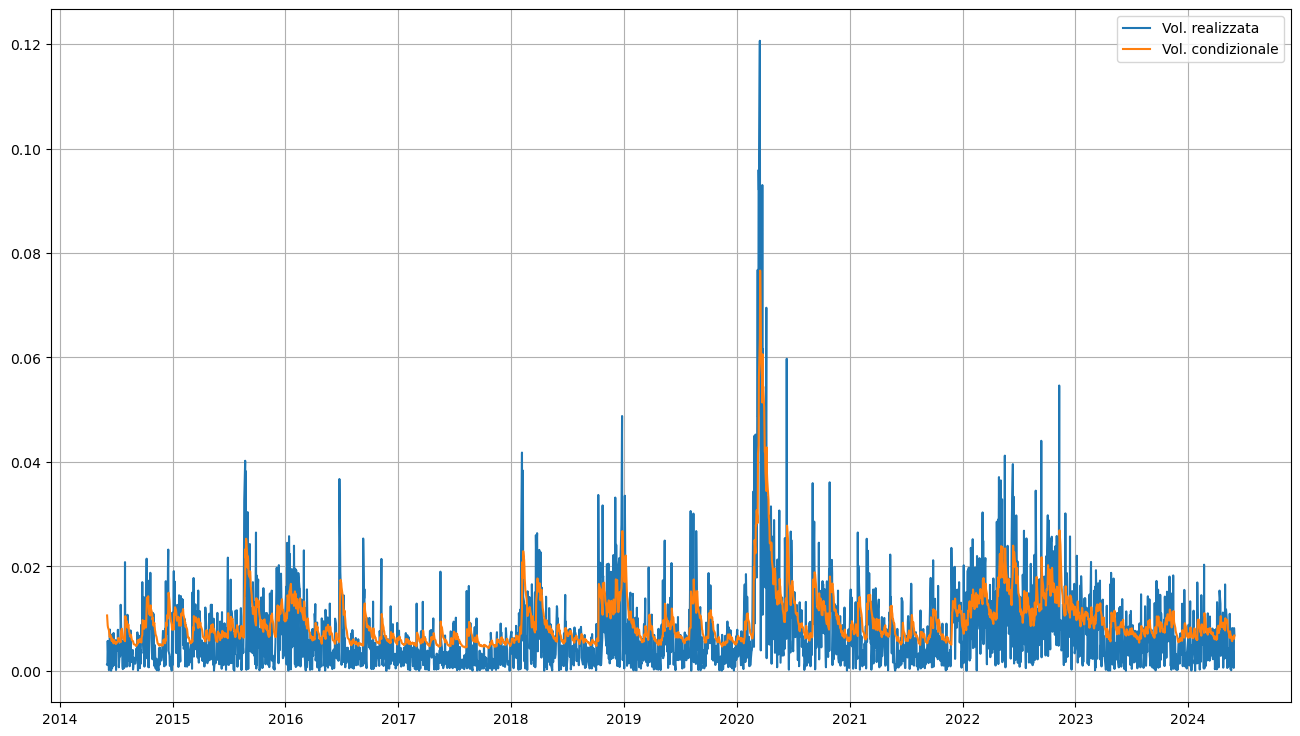

In [47]:
plt.figure(figsize = (16,9))
plt.rc('xtick', labelsize = 10)
plt.plot(prices.index[1:],realized,label = 'Vol. realizzata')
plt.plot(prices.index[1:], conditional, label = 'Vol. condizionale')
plt.legend()
plt.grid(True)
#plt.ylim(0, 0.05)
plt.show()
